In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import os
import datetime

experiment_id = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
experiment_id

directory = 'drive/MyDrive/experiment/'+experiment_id

try :
    if not os.path.exists(directory) :
        os.makedirs(directory)

except OSError :
        print ('Error: Creating directory. ' +  directory)

In [ ]:
directory

'drive/MyDrive/experiment/2022_06_26_12_37'

In [ ]:
import numpy as np

class demand_generator(object):
    def __init__(self, demand_max = 5, demand_var =2  , time_length =26, random_variable = 'uniform'):
        self.demand_max = demand_max
        self.demand_var = demand_var
        self.random_variable = random_variable
        self.time_length = time_length


    def generate_demand(self,time_step):

        if self.random_variable =='seasonal':
            time_step = time_step % 24
            return np.round(self.demand_max/2 + self.demand_max/2*np.sin(4*np.pi*(time_step + 2)/self.time_length*2) ,2)
        elif self.random_variable =='seasonal_uniform':
            time_step = time_step % 24
            return np.round(self.demand_max/2 + self.demand_max/2*np.sin(4*np.pi*(time_step + 2)/self.time_length*2) + np.random.uniform(0, self.demand_var) ,2)
        elif self.random_variable == 'constant':
            return np.round(self.demand_max/2,2)
        elif self.random_variable == 'constnat_uniform':
            return np.round(self.demand_max/2 + np.random.uniform(0, self.demand_var),2)
        elif self.random_variable =='linear_drop' :
            t = time_step % 6+1 ## 6 denote cylce
            return np.round(self.demand_max/5*t, 2) # just form of linear regression
        elif self.random_variable =='linear_drop_unifrom':
            t = time_step % 6+1
            return np.round(self.demand_max/5*t + np.random.uniform(0, self.demand_var),2)
        else :
            print("none of matched")

    def generate_all_demand(self):
        self.demand_history = []

        for time_step in range(self.time_length):
            self.demand_history.append(self.generate_demand(time_step))
        return self.demand_history

    def reset(self):
        self.demand_max = demand_max
        self.demand_var = demand_var
        self.random_variable =  random_variable
        self.length = length

def make_window(demand_history, window_size = 4):
    window_array = []
    for i in reversed(range(window_size)):
        window = demand_history[:window_size-i-1]
        while len(window) != window_size :
            window.insert(0,0.0)

        window_array.append(window)

    for i in range(len(demand_history)):
        if i-window_size> 0 :
            window = demand_history[i-window_size:i]
            window_array.append(window)



    return window_array


class SCM_env(object):
    def __init__(self, demand_history):
        self.demand_history = demand_history

        self.factory_wh_cap = 15
        self.dt_wh_cap = 10

        self.factory_wh_stock = 0
        self.dt_wh_stock = 0


        self.unit_price = 100
        self.unit_cost = 40
        self.storage_cost = 2
        self.transportation_cost=5

        self.T = 52
        self.t = 0
        self.demand_window = make_window(demand_history)

        self.state  = [self.factory_wh_stock, self.dt_wh_stock, *self.demand_window[self.t], self.t ]

    # initialize setting return initial state
    def reset(self):
        self.factory_wh_stock = 0
        self.dt_wh_stock = 0
        self.demand_history = demand_history
        self.demand_window = make_window(demand_history)
        self.t = 0
        self.state =[self.factory_wh_stock, self.dt_wh_stock,self.demand_window[self.t][0]]
        return self.state



    def step(self, action):
        production_level = action[0]
        shipping_num = action[1]


        production_level = min(production_level,  self.factory_wh_cap-self.factory_wh_stock)
        production_cost =  self.unit_cost * production_level

        # ca store  only factory_wh capacity
        self.factory_wh_stock = min(self.factory_wh_stock + production_level, self.factory_wh_cap)
        storage_cost = self.storage_cost * self.factory_wh_stock

        shipping_num = min(shipping_num, self.factory_wh_stock)
        transportation_cost = self.transportation_cost * shipping_num

        self.factory_wh_stock = max(self.factory_wh_stock - shipping_num, 0)

        self.dt_wh_stock = min(self.dt_wh_stock + shipping_num, self.dt_wh_cap)
        storage_cost += 1.5*self.storage_cost * self.dt_wh_stock


        demand = self.demand_history[self.t]
        demand_meeting = self.dt_wh_stock-demand

        if demand_meeting >= 0 : # meeting all demands
            revenue = self.unit_price * demand
            self.dt_wh_stock -= demand
            penalty_cost= 0

        else :
            revenue = self.unit_price * self.dt_wh_stock ## sell availabe warehouse stock
            penalty_cost = self.unit_price *(demand - self.dt_wh_stock) ## penalty cost for remaining quantity
            self.dt_wh_stock = 0

        profit = revenue - production_cost-storage_cost-transportation_cost-penalty_cost
        self.t+=1
        self.state = [self.factory_wh_stock, self.dt_wh_stock, *self.demand_window[self.t], self.t]

        return self.state, [profit,revenue, production_cost,storage_cost,transportation_cost, penalty_cost], self.t == 48

In [ ]:
import numpy as np
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
            name, chkpt_dir=directory):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
            n_actions, name, chkpt_dir=directory):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = 20*T.tanh(self.mu(prob))

        return mu

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


class Agent():
    def __init__(self, alpha, beta, input_dims, tau,
            gamma=0.99, update_actor_interval=2, warmup=1000,
            n_actions=2, max_size=1000000, layer1_size=400,
            layer2_size=300, batch_size=100, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.max_action = [20]
        self.min_action = [0]
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='actor')

        self.critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_2')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                    layer2_size, n_actions=n_actions, name='target_actor')
        self.target_critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_2')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=self.noise,
                                            size=(self.n_actions,)))
        else:
            state = T.tensor(observation, dtype=T.float).to(self.actor.device)
            mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=self.noise),
                                    dtype=T.float).to(self.actor.device)

        mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0])
        self.time_step += 1

        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic_1.device)
        done = T.tensor(done).to(self.critic_1.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.critic_1.device)
        state = T.tensor(state, dtype=T.float).to(self.critic_1.device)
        action = T.tensor(action, dtype=T.float).to(self.critic_1.device)

        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        target_actions = T.clamp(target_actions, self.min_action[0],
                                self.max_action[0])

        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = -T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1 = dict(critic_1_params)
        critic_2 = dict(critic_2_params)
        actor = dict(actor_params)
        target_actor = dict(target_actor_params)
        target_critic_1 = dict(target_critic_1_params)
        target_critic_2 = dict(target_critic_2_params)

        for name in critic_1:
            critic_1[name] = tau*critic_1[name].clone() + \
                    (1-tau)*target_critic_1[name].clone()

        for name in critic_2:
            critic_2[name] = tau*critic_2[name].clone() + \
                    (1-tau)*target_critic_2[name].clone()

        for name in actor:
            actor[name] = tau*actor[name].clone() + \
                    (1-tau)*target_actor[name].clone()

        self.target_critic_1.load_state_dict(critic_1)
        self.target_critic_2.load_state_dict(critic_2)
        self.target_actor.load_state_dict(actor)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

## Train

In [ ]:


agent = Agent(alpha=0.001, beta=0.001,
        input_dims=[7], tau=0.01, batch_size=32, layer1_size=64, layer2_size=64,max_size=5000, noise=0.4, n_actions=2)

n_games = 1000
profit_history = []
best_score = -100000


episode_logs = open(directory + "/episode_log.txt", "w")
for i in range(n_games):
    demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'seasonal_uniform')
    demand_history = demand_gen.generate_all_demand()
    env = SCM_env(demand_history)
    observation = env.state
    done = False

    profits = 0
    revenues = 0
    storage_costs = 0
    transporation_costs = 0
    production_costs = 0
    penalty_costys = 0

    while not done:
        action = agent.choose_action(observation)
        observation_, reward_lst, done = env.step(action)
        profit, revenue, production_cost,\
        storage_cost,transporation_cost,\
        penalty_costy = reward_lst[0], reward_lst[1],reward_lst[2],reward_lst[3],reward_lst[4],reward_lst[5] # profit
        #print(observation)

        agent.remember(observation, action, profit, observation_, done)
        agent.learn()

        profits += profit
        revenues += revenue
        storage_costs +=  storage_cost
        transporation_costs += transporation_cost
        production_costs += production_cost
        penalty_costys += penalty_costy
        observation = observation_
        avg_profit = np.mean(profit_history[-10:])

        if i> 0 and  avg_profit > best_score :
            print(f"--------------- save model :{avg_profit :.3f} , best:{best_score :.3f} -------- ")
            best_score = avg_profit
            agent.save_models()


    profit_history.append(profits)
    #avg_profit = np.mean(profit_history[-100:])
    this_episode = f"""episode:{i}, profit:{profits:.2f}, avg_profit:{np.mean(profit_history[-10:]):.2f}, revenue:{revenues:.2f}, storage_cost:{storage_costs:.2f}, transportaion_cost:{transporation_costs:.2f}, production_costs:{production_costs:.2f}, penalty_cost:{penalty_costys:.2f}"""
    print(this_episode)
    episode_logs.write(this_episode + "\r")
    episode_logs.flush()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode:0, profit:-15536.13, avg_profit:-15536.13, revenue:1028.21, storage_cost:99.20, transportaion_cost:51.41, production_costs:460.94, penalty_cost:15952.79
--------------- save model :-15536.125 , best:-100000.000 -------- 
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode:1, profit:-15877.81, avg_profit:-15706.97, revenue:460.93, storage_cost:58.25, transportaion_cost:23.05, production_costs:184.37, penalty_cost:16073.07
episode:2, profit:-15375.00, avg_profit:-15596.31, revenue:595.55, storage_cost:40.46, transportaion_cost:29.78, production_costs:240.87, penalty_cost:15659.45
episode:3, profit:-15789.05, avg_profit:-15644.50, revenue:692.82, storage_cost:200.16, transportaion_cost:34.64, production_costs:383.90, penalty_cost:15863.18
episode:4, profit:-15295.69, avg_profit:-15574.74, revenue:998.08, storage_cost:175.71, transportaion_cost:49.90, production_costs:447

## 벤치마크 실험


In [ ]:
def bench_mark(state,time_step, random_variable ,fw_max_cap=15, dh_max_cap=10, time_length =52 ):
    demand_max = 5
    demand_var = 2

    if random_variable =='seasonal':
        time_step = time_step % 24
        average_demand = np.round(demand_max/2 + demand_max/2*np.sin(4*np.pi*(time_step + 2)/time_length*2) ,2)

    elif random_variable == 'constant':
        average_demand = np.round(demand_max/2,2)

    elif random_variable =='linear_drop' :
        t = time_step % 6+1 ## 6 denote cylce
        average_demand = np.round(demand_max/5*t, 2) # just form of linear regression
    else :
        print("none of matched")

    factory_wh_stock = state[0]
    dt_wh_stock = state[1]

    """
    state [self.factory_wh_stock, self.dt_wh_stock, *self.demand_window[self.t], self.t ]
    """
    if factory_wh_stock <= 0 :
        production_level = fw_max_cap
    else:
        production_level = 0

    if dt_wh_stock <= average_demand:
        transport_level = dh_max_cap - dt_wh_stock

    else :
        transport_level = 0


    return production_level, transport_level

벤치마크 실험

In [ ]:


n_games = 1000
bench_profit_history = []
best_score = -100000


bench_episode_logs = open(directory + "/bench_episode_log.txt", "w")
for i in range(n_games):
    demand_gen = demand_generator(demand_max = 5, demand_var =2.5  , time_length =52, random_variable = 'seasonal_uniform')
    demand_history = demand_gen.generate_all_demand()
    env = SCM_env(demand_history)
    observation = env.state
    done = False

    profits = 0
    revenues = 0
    storage_costs = 0
    transporation_costs = 0
    production_costs = 0
    penalty_costys = 0

    time_step = 0

    while not done:
        action = bench_mark(observation, time_step=time_step, random_variable='seasonal')
        observation_, reward_lst, done = env.step(action)
        profit, revenue, production_cost,\
        storage_cost,transporation_cost,\
        penalty_costy = reward_lst[0], reward_lst[1],reward_lst[2],reward_lst[3],reward_lst[4],reward_lst[5] # profit


        profits += profit
        revenues += revenue
        storage_costs +=  storage_cost
        transporation_costs += transporation_cost
        production_costs += production_cost
        penalty_costys += penalty_costy
        observation = observation_
        avg_profit = np.mean(profit_history[-10:])
        time_step+=1


    bench_profit_history.append(profits)
    #avg_profit = np.mean(profit_history[-100:])
    this_episode = f"""episode:{i}, profit:{profits:.2f}, avg_profit:{np.mean(profit_history[-10:]):.2f}, revenue:{revenues:.2f}, storage_cost:{storage_costs:.2f}, transportaion_cost:{transporation_costs:.2f}, production_costs:{production_costs:.2f}, penalty_cost:{penalty_costys:.2f}"""
    print(this_episode)
    bench_episode_logs.write(this_episode + "\r")
    bench_episode_logs.flush()



episode:0, profit:5836.39, avg_profit:7716.04, revenue:16141.00, storage_cost:1742.61, transportaion_cost:825.00, production_costs:6600.00, penalty_cost:1137.00
episode:1, profit:6336.12, avg_profit:7716.04, revenue:17473.00, storage_cost:1705.88, transportaion_cost:875.00, production_costs:7200.00, penalty_cost:1356.00
episode:2, profit:6454.66, avg_profit:7716.04, revenue:17185.00, storage_cost:1757.34, transportaion_cost:875.00, production_costs:7200.00, penalty_cost:898.00
episode:3, profit:6642.85, avg_profit:7716.04, revenue:17117.00, storage_cost:1741.20, transportaion_cost:874.95, production_costs:7200.00, penalty_cost:658.00
episode:4, profit:6969.06, avg_profit:7716.04, revenue:17259.00, storage_cost:1816.29, transportaion_cost:874.65, production_costs:7200.00, penalty_cost:399.00
episode:5, profit:5612.14, avg_profit:7716.04, revenue:16000.00, storage_cost:1756.86, transportaion_cost:800.00, production_costs:6600.00, penalty_cost:1231.00
episode:6, profit:6609.36, avg_profit

## log 파일 load 분석


In [ ]:
    with open(txt_name,'r') as file :
        lines = file.readlines()
    cost_bill = []
    temp_penalty= []
    temp = []
    total_cost = []
    reward = []

    for i in range(len(lines)):
        cost_bill.append(float(lines[i].split(',')[3].split(":")[1]))
        temp_penalty.append(float(lines[i].split(',')[4].split(":")[1]))
        temp.append(float(lines[i].split(',')[2].split(":")[1]))
        total_cost.append(float(lines[i].split(',')[5].split(":")[1]))
        reward.append(float(lines[i].split(',')[6].split(":")[1]))

NameError: ignored

In [ ]:
with open(directory + "/bench_episode_log.txt",'r') as f :
    lines = f.readlines()

profit_b = []
revenue_b = []
storage_cost_b = []
transporation_cost_b = []
production_cost_b =[]
pnealty_cost_b = []


for i in range(len(lines)):
    profit_b.append(float(lines[i].split(',')[1].split(":")[1]))
    revenue_b.append(float(lines[i].split(',')[3].split(":")[1]))
    storage_cost_b.append(float(lines[i].split(',')[4].split(":")[1]))
    transporation_cost_b.append(float(lines[i].split(',')[5].split(":")[1]))
    production_cost_b.append(float(lines[i].split(',')[6].split(":")[1]))
    pnealty_cost_b.append(float(lines[i].split(',')[7].split(":")[1]))


In [ ]:
with open(directory + "/episode_log.txt",'r') as f :
    lines = f.readlines()

profit= []
revenue = []
storage_cost= []
transporation_cost = []
production_cost =[]
pnealty_cost = []


for i in range(len(lines)):
    profit.append(float(lines[i].split(',')[1].split(":")[1]))
    revenue.append(float(lines[i].split(',')[3].split(":")[1]))
    storage_cost.append(float(lines[i].split(',')[4].split(":")[1]))
    transporation_cost.append(float(lines[i].split(',')[5].split(":")[1]))
    production_cost.append(float(lines[i].split(',')[6].split(":")[1]))
    pnealty_cost.append(float(lines[i].split(',')[7].split(":")[1]))


In [ ]:
tmp = max(profit_b)
index = profit_b.index(tmp)
print(index)

469


In [ ]:
print("bench_mark")
print(f'max profit : {profit_b[index]}')
print(f'revenue : {revenue_b[index]}')
print(f'average transporation : {transporation_cost_b[index]}')
print(f'average production : {production_cost_b[index]}')
print(f'average penalty_cost : {pnealty_cost_b[index]}')
print(f'average storage_cost : {storage_cost_b[index]}')


bench_mark
max profit : 7456.7
revenue : 17821.0
average transporation : 900.0
average production : 7200.0
average penalty_cost : 448.0
average storage_cost : 1816.3


In [ ]:
tmp = max(profit)
index = profit.index(tmp)
print(index)

371


In [ ]:
print("agent")
print(f'max profit : {profit[index]}')
print(f'revenue : {revenue[index]}')
print(f'transporation : {transporation_cost[index]}')
print(f'production : {production_cost[index]}')
print(f'penalty_cost : {pnealty_cost[index]}')
print(f'storage_cost : {storage_cost[index]}')


agent
max profit : 8383.53
revenue : 17448.0
transporation : 876.56
production : 7012.52
penalty_cost : 0.0
storage_cost : 1175.39


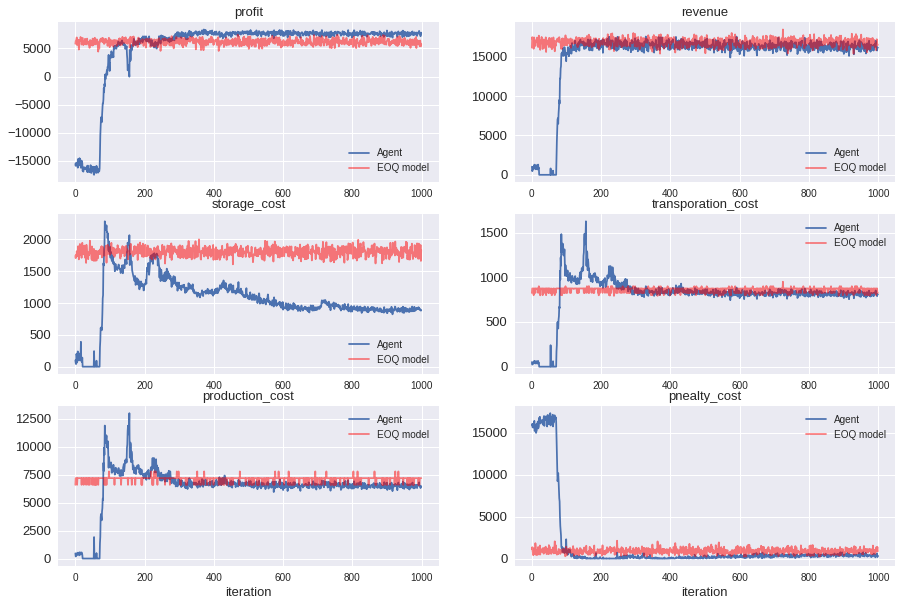

In [ ]:
import matplotlib.pyplot as plt
parameters = {'axes.labelsize': 13,
          'axes.titlesize': 13,
          'ytick.labelsize':13}
plt.rcParams.update(parameters)


fig, axes= plt.subplots(3,2, figsize=(15,10))
axes[0][0].plot(profit, label='Agent')
axes[0][0].plot(profit_b, label="EOQ model", color='red',alpha=0.5)
axes[0][0].legend()
axes[0][0].set_title("profit")

axes[0][1].plot(revenue, label='Agent')
axes[0][1].plot(revenue_b, label="EOQ model",  color='red',alpha=0.5)
axes[0][1].legend()
axes[0][1].set_title("revenue")
#axes[0][1].set_xlabel("iteration")

axes[1][0].plot(storage_cost, label='Agent')
axes[1][0].plot(storage_cost_b, label="EOQ model",  color='red',alpha=0.5)
axes[1][0].legend()
axes[1][0].set_title("storage_cost")
#axes[1][0].set_xlabel("iteration")

axes[1][1].plot(transporation_cost, label='Agent')
axes[1][1].plot(transporation_cost_b, label="EOQ model", color='red',alpha=0.5)
axes[1][1].legend()
axes[1][1].set_title("transporation_cost")
#axes[1][1].set_xlabel("iteration")


axes[2][0].plot(production_cost, label='Agent')
axes[2][0].plot(production_cost_b, label="EOQ model", color='red',alpha=0.5)
axes[2][0].legend()
axes[2][0].set_title("production_cost")
axes[2][0].set_xlabel("iteration")

axes[2][1].plot(pnealty_cost, label='Agent')
axes[2][1].plot(pnealty_cost_b, label="EOQ model", color='red',alpha=0.5)
axes[2][1].legend()
axes[2][1].set_title("pnealty_cost")
axes[2][1].set_xlabel("iteration")

plt.savefig(directory+'/plot.png',dpi=100)

In [ ]:
directory

'drive/MyDrive/experiment/2022_06_06_09_42'

In [ ]:
demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'seasonal')
demand_seasonal = demand_gen.generate_all_demand()

demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'constant')
demand_constant = demand_gen.generate_all_demand()

demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'linear_drop')
demand_linear = demand_gen.generate_all_demand()


demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'seasonal_uniform')
demand_seasonal_rnd = demand_gen.generate_all_demand()

demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'constnat_uniform')
demand_constant_rnd = demand_gen.generate_all_demand()

demand_gen = demand_generator(demand_max = 5, demand_var =2  , time_length =52, random_variable = 'linear_drop_unifrom')
demand_linear_rnd = demand_gen.generate_all_demand()


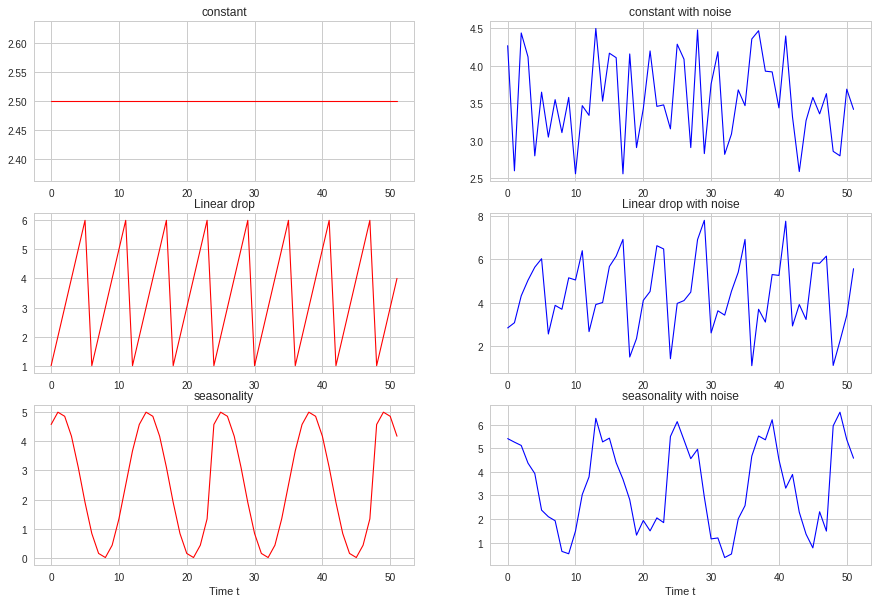

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 14,
          'ytick.labelsize':20}
fig, axes= plt.subplots(3,2, figsize=(15,10))

# constnat
axes[0][0].plot(demand_constant,color='red', linewidth=1.1)
axes[0][0].set_title("constant")
axes[0][1].plot(demand_constant_rnd,color='blue', linewidth=1.1)
axes[0][1].set_title("constant with noise")
# linear
axes[1][0].plot(demand_linear,color='red', linewidth=1.1)
axes[1][0].set_title("Linear drop")

axes[1][1].plot(demand_linear_rnd,color='blue', linewidth=1.1)
axes[1][1].set_title("Linear drop with noise")

axes[2][0].plot(demand_seasonal,color='red', linewidth=1.1)
axes[2][1].set_title("seasonality")

axes[2][0].set_title("seasonality")
axes[2][1].plot(demand_seasonal_rnd,color='blue', linewidth=1.1)
axes[2][1].set_title("seasonality with noise")
axes[2][1].grid()

axes[2][0].set_xlabel("Time t")
axes[2][1].set_xlabel("Time t")
plt.grid()
plt.savefig(directory+'/demand_plot.png',dpi=100)
